In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import operator
from functools import reduce
from pandas import concat
import math
from math import pi
from sklearn.datasets import load_boston
import copy
from sklearn.ensemble import RandomForestRegressor

In [9]:
def getDistance(latA, lonA, latB, lonB):
    ra = 6378136.49  # radius of equator: meter
    rb = 6356755  # radius of polar: meter

    flatten = (ra - rb) / ra  # Partial rate of the earth
    # change angle to radians
    radLatA = math.radians(latA)
    radLonA = math.radians(lonA)
    radLatB = math.radians(latB)
    radLonB = math.radians(lonB)
 
    pA = math.atan(rb / ra * math.tan(radLatA))
    pB = math.atan(rb / ra * math.tan(radLatB))
    if radLonA == radLonB:
        x = math.acos(math.sin(pA) * math.sin(pB) + math.cos(pA) * math.cos(pB) * math.cos(0.001))
    else:
        x = math.acos(math.sin(pA) * math.sin(pB) + math.cos(pA) * math.cos(pB) * math.cos(radLonA - radLonB))
    c1 = (math.sin(x) - x) * (math.sin(pA) + math.sin(pB))**2 / math.cos(x / 2)**2
    c2 = (math.sin(x) + x) * (math.sin(pA) - math.sin(pB))**2 / math.sin(x / 2)**2
    dr = flatten / 8 * (c1 - c2)
    distance = ra * (x + dr)/1000
    
    dLon = radLonB - radLonA
    yy = math.sin(dLon) * math.cos(radLatB)
    xx = math.cos(radLatA) * math.sin(radLatB) - math.sin(radLatA) * math.cos(radLatB) * math.cos(dLon)
    brng = math.degrees(math.atan2(yy, xx))
    brng = (brng + 180) % 360
#     if brng>180:
#         brng=brng-360
#     brng=brng*math.pi/180
    return distance,brng

In [2]:
data_track=pd.read_csv(r'./IBTrACS_fore72.txt',sep=',',header=None,names=['name','date','lat','lon','ws','p','speed','direct'])
index_i=[]
for i in range(len(data_track)):
    if data_track.name[i]=='66666':
        index_i.append(i) 
data_track=data_track.drop(columns=['name','date'])

In [6]:
def dis_direct(data,forecast_hour):
    dif_essemble=[]
    point=8
    for i in range(len(data)):
        x_essemble=[]
        for j in range(0,8,1):
            lon0=data[i][point*6+1]
            lat0=data[i][point*6]
            lon1=data[i][j*6+1]
            lat1=data[i][j*6]
            lat2=data[i][(j+1)*6]
            lon2=data[i][(j+1)*6+1]
            ws=data[i][(j+1)*6+2]
            p=data[i][(j+1)*6+3]
            speed=data[i][(j+1)*6+4]
            direct=data[i][(j+1)*6+5]
            distance,brng=getDistance(lat1, lon1, lat0, lon0)                                        
            f2=math.sin(lat2*pi/180)
            x_essemble.append(lat2)  #0 
            x_essemble.append(lon2)#1
            x_essemble.append(ws)#2
            x_essemble.append(p)#3
            x_essemble.append(distance)#4
            x_essemble.append(brng)#5
            x_essemble.append(speed)#6
            x_essemble.append(direct)#7
            x_essemble.append(f2)#8
            dif_lat=data[i][point*6]-data[i][j*6]
            dif_lon=data[i][point*6+1]-data[i][j*6+1]
            dif_direct=data[i][point*6+5]-data[i][j*6+5]
            dif_speed=data[i][point*6+4]-data[i][j*6+4]
            dif_p=data[i][point*6+3]-data[i][j*6+3]
            dif_ws=data[i][point*6+2]-data[i][j*6+2]
            x,brngx=getDistance(lat1, lon1, lat1, lon0)
            y,brngy=getDistance(lat1, lon1, lat0, lon1)
            xx,brngxx=getDistance(lat1, lon1, lat1, lon2)
            yy,brngyy=getDistance(lat1, lon1, lat2, lon1)
            if dif_lon<=0:
                x=x
            else:
                x=-x
            if dif_lat>=0:
                y=y
            else:
                y=-y
            if lon2<=lon1:
                u=xx/360
            else:
                u=0-xx/360
            if lat2>=lat1:
                v=yy/360
            else:
                v=0-yy/360  
            x_essemble.append(dif_lat)#9
            x_essemble.append(dif_lon)#10
            x_essemble.append(x)#11
            x_essemble.append(y)#12
            x_essemble.append(u)#13
            x_essemble.append(v)#14
            x_essemble.append(dif_ws)#15
            x_essemble.append(dif_p)#16
            x_essemble.append(dif_speed)#17 
            x_essemble.append(dif_direct)#18
        for j in range(1,25,2):
            dif_lat=data[i][54+j]-data[i][point*6]
            dif_lon=data[i][54+j+24]-data[i][point*6+1]
            x_essemble.append(dif_lat)#9
            x_essemble.append(dif_lon)#10
        x_essemble.append(lat0)
        x_essemble.append(lon0)
        dif_essemble.append(x_essemble)
    return dif_essemble


In [7]:
def shift(data,forcast_hour):
    cols=[]
    lat_data=data['lat']
    lon_data=data['lon']
    m=int(forcast_hour/3)
    n=int(forcast_hour/6)-1
    for i in range(32,23,-1):
        cols.append(data.shift(i))
    for i in range(23,-1,-1):
        cols.append(lat_data.shift(i))
    for i in range(23,-1,-1):
        cols.append(lon_data.shift(i))        
    agg = pd.concat(cols, axis=1)
    essemble=agg.dropna(axis=0,how='any')
    return essemble

In [10]:
essemble_test=[]
for i in range(len(index_i)):
    m=index_i[i]+1       
    if i ==len(index_i)-1:
        n=len(data_track)
    else:
        n=index_i[i+1]
    data=data_track[m:n]
    dataframe_track=pd.DataFrame(data)
    essemble=shift(dataframe_track,72)
    essemble_values=essemble.values
    essemble_list=essemble_values.tolist()
    dif_data=dis_direct(essemble_list,72)
    essemble_test.append(dif_data)
essemble_ds=reduce(operator.add, essemble_test)

In [12]:
essemble_all_72=np.array(essemble_ds)

In [11]:
def random_fit(essemble_all,forecast_hour):
#     essemble_all=np.array(essemble_all)
    result=0
    result_oob=0
    point=int(forecast_hour/6)
    result_ds=[]
    for i in range(0,8):
        X = essemble_all[:,19*i:19*(i+1)]
        Y = essemble_all[:,(8*19):(8*19+24)]
        rf = RandomForestRegressor(random_state=200,oob_score=True)
        rf.fit(X, Y)
        result+=rf.feature_importances_ 
        result_ds.append(rf.feature_importances_)
        result_oob+=rf.oob_score_ 
    importance_feature=result/8
    return importance_feature,result_ds

In [13]:
importance_feature_ds,result_ds=random_fit(essemble_all_72,72)

In [14]:
print(importance_feature_ds)

[0.04100276 0.07946465 0.03154965 0.03683345 0.02472393 0.33575586
 0.01160567 0.02274279 0.03974742 0.02963065 0.05160935 0.05701175
 0.03829363 0.02284275 0.02320577 0.0217822  0.02271743 0.03993541
 0.06954489]


In [19]:
def select_combine(essemble_all,features_imp,select_num,forecast_hour):
#     i=int(forecast_hour/6)
    essemble_all=np.array(essemble_all)
    X1 = essemble_all[:,0:152]
    X_train=X1.reshape(-1,8,19)
    y_train = essemble_all[:,19*8:19*8+8]
    oob_result = []
    fea_result = []
    features_imp = list(features_imp)
    iter_count = 19 - select_num  #迭代次数
    if iter_count < 0:
        print("select_nume must less or equal X_train columns")
    else:
        features_test  = copy.deepcopy(features_imp)   #生成一个排序特征，进行筛选
        features_test.sort()
        features_test.reverse() 
        while iter_count >= 0:
            iter_count -= 1
            train_index = [features_imp.index(j) for j in features_test[:select_num]]
            train_data = X_train[:,:,train_index]
            acc=0
            for m in range(8):
                train_x=train_data[:,m,:]
                rf = RandomForestRegressor(random_state=200,oob_score=True)
                rf.fit(train_x,y_train)
                acc += rf.oob_score_
                print(acc)
            acc=acc/8
            print(acc)
            oob_result.append(acc)
            fea_result.append(train_index)
            if select_num < 19:
                select_num += 1
            else:
                break
    return max(oob_result),oob_result,fea_result[oob_result.index(max(oob_result))]

In [31]:
print(score_max_72,oob_score_72,fea_result_72)

0.8008875734515973 [0.12645838910573517, 0.38476574094874944, 0.5284972340319037, 0.6579031378653257, 0.6647070699850531, 0.7379163388730079, 0.7543143519799368, 0.7549527863948922, 0.7682793053153428, 0.7951716856833255, 0.8008875734515973, 0.8002502593211684, 0.7984808615620558, 0.796056942541798, 0.793700357331257, 0.7925392393641042, 0.7962638727684801, 0.7976076059308658, 0.7982262518955276] [5, 1, 18, 11, 10, 0, 17, 8, 12, 3, 2]


In [4]:
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties

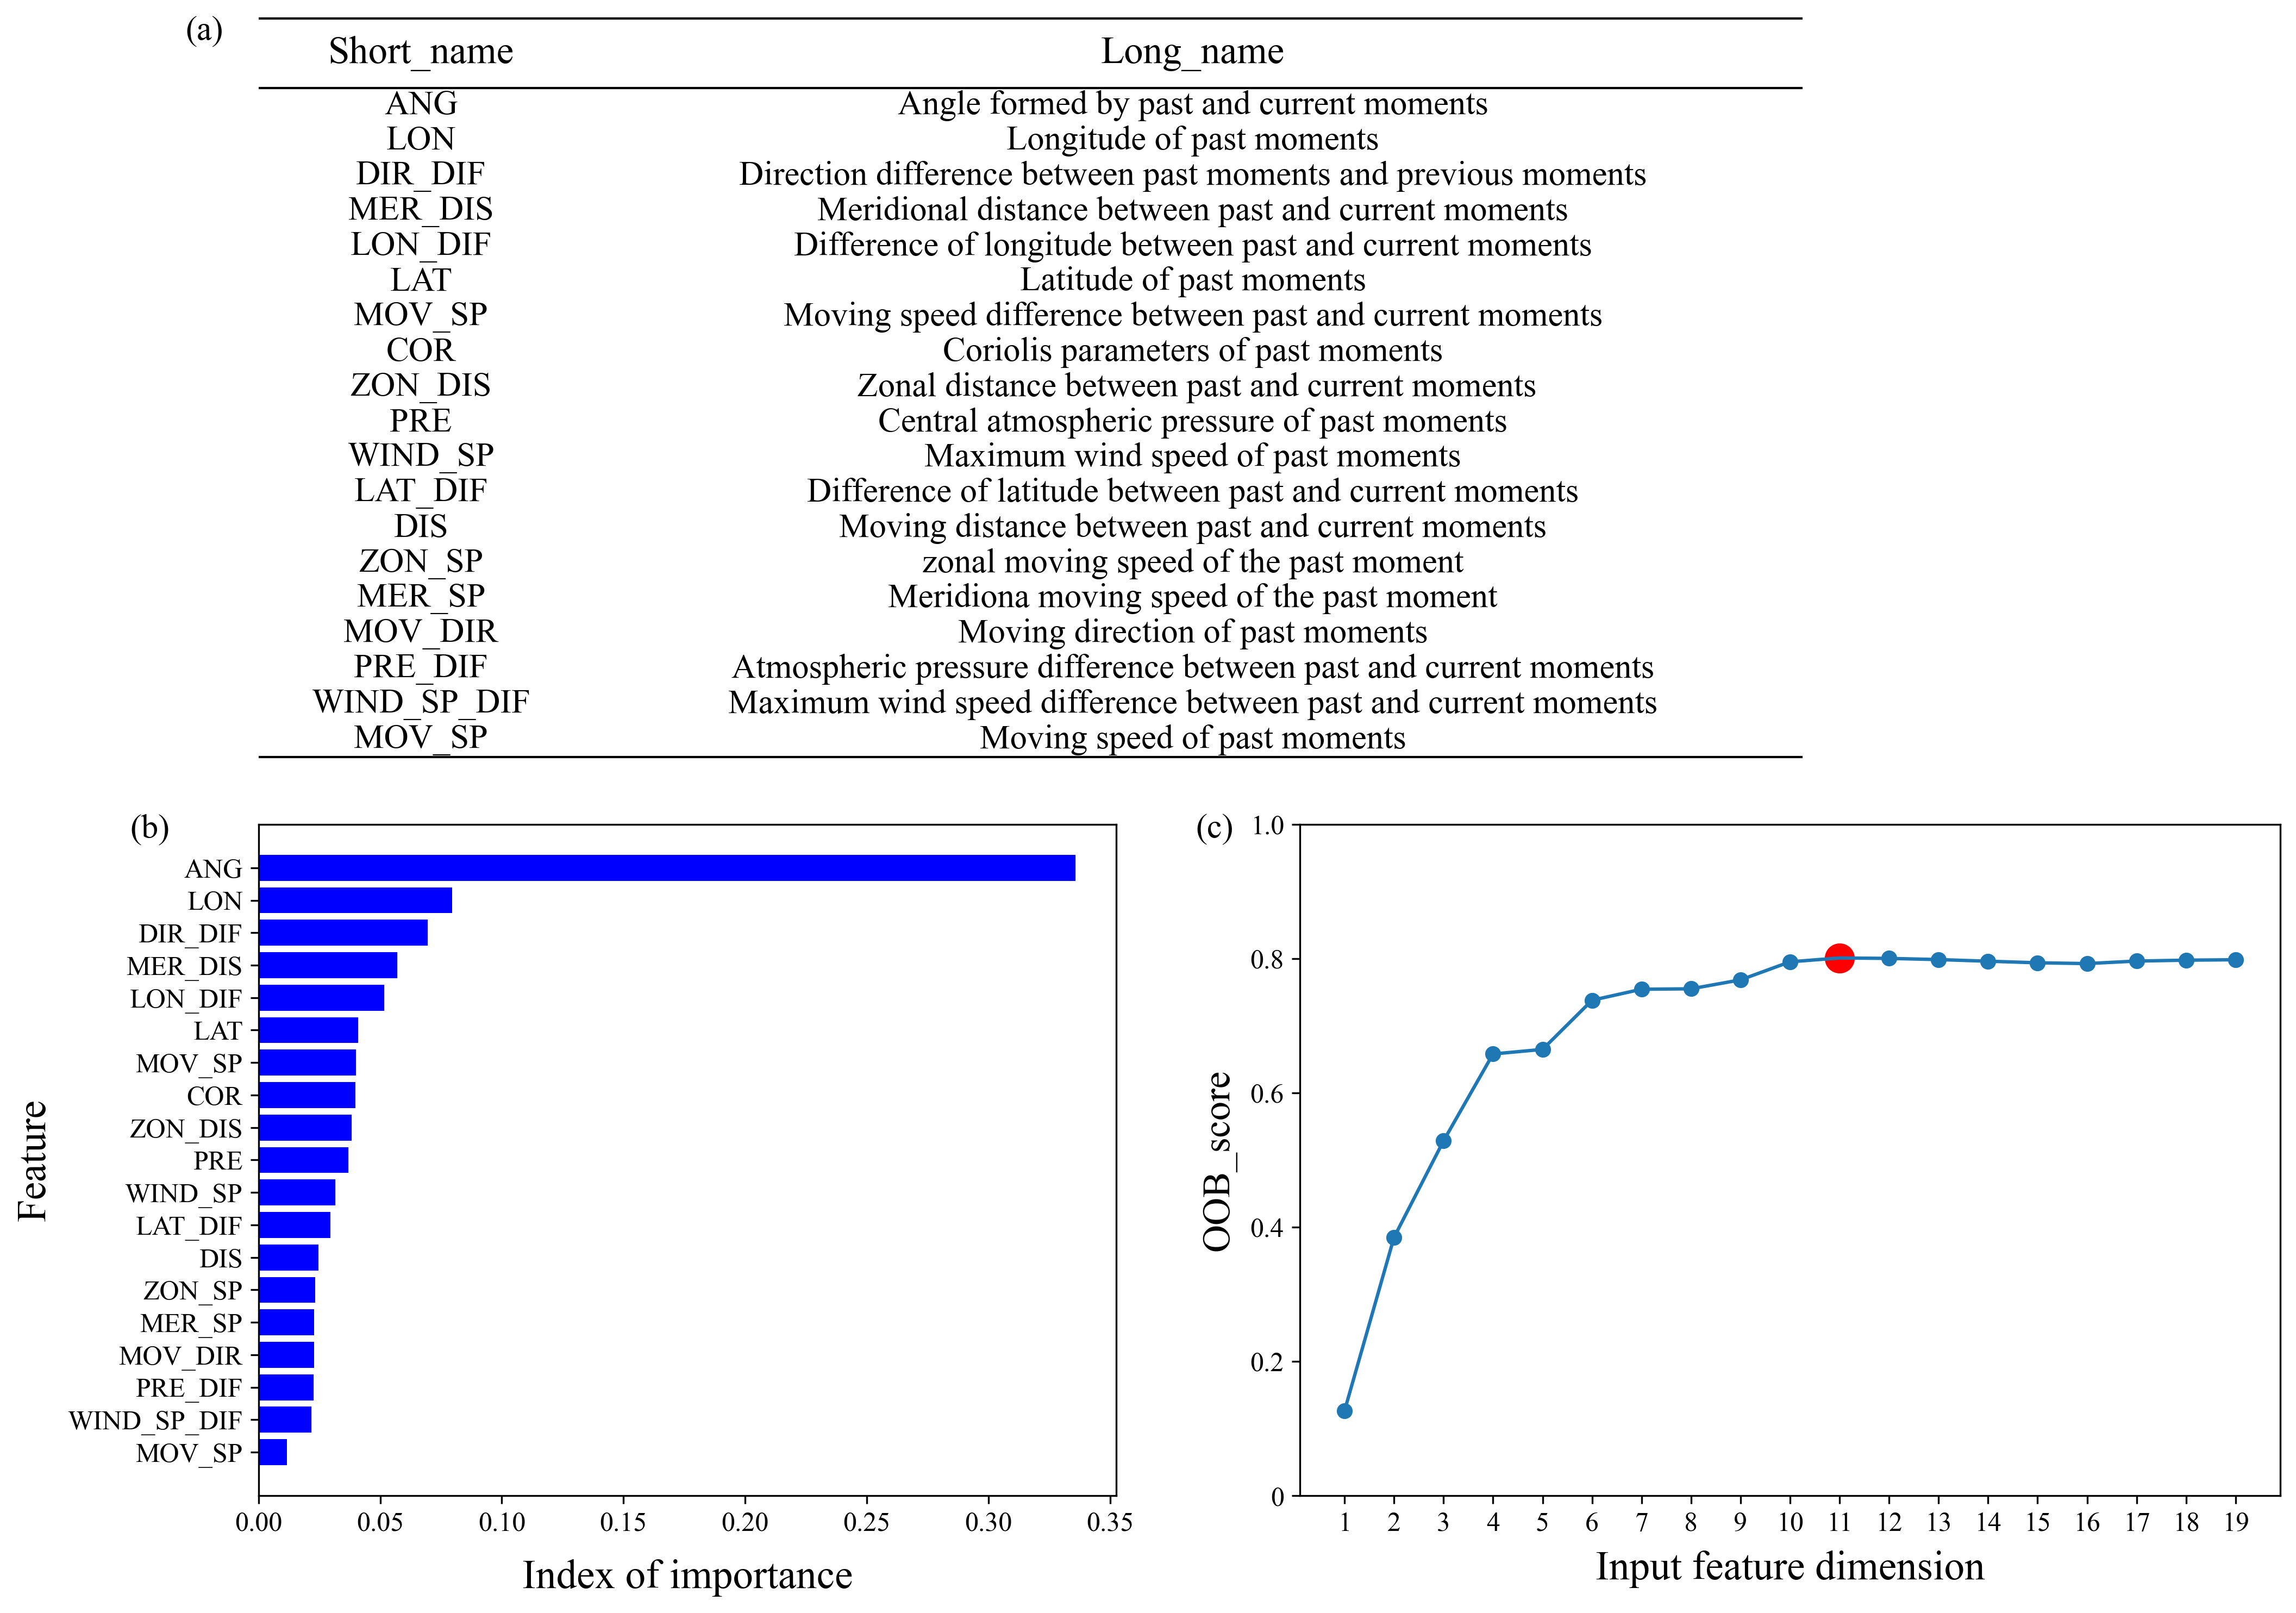

In [75]:
fig = plt.figure(figsize=(16, 12), dpi=300)
plt.rcParams.update({'font.family': 'Times New Roman','font.size': 12})
# matplotlib.rc("font",family='SimHei')
long_names=['Latitude of past moments', 'Longitude of past moments', 'Maximum wind speed of past moments', 'Central atmospheric pressure of past moments', 'Moving distance between past and current moments', 'Angle formed by past and current moments',
           'Moving speed of past moments','Moving direction of past moments', 'Coriolis parameters of past moments', 'Difference of latitude between past and current moments', 'Difference of longitude between past and current moments',
           'Meridional distance between past and current moments', ' Zonal distance between past and current moments', 'Meridiona moving speed of the past moment', 'zonal moving speed of the past moment',
           'Maximum wind speed difference between past and current moments', 'Atmospheric pressure difference between past and current moments', 'Moving speed difference between past and current moments', 'Direction difference between past moments and previous moments']
y_pos = np.arange(1,20)
short_name=['ANG','LON','DIR_DIF','MER_DIS','LON_DIF','LAT','MOV_SP','COR','ZON_DIS','PRE','WIND_SP','LAT_DIF','DIS','ZON_SP','MER_SP','MOV_DIR','PRE_DIF','WIND_SP_DIF','MOV_SP']
var_names=np.array(short_name[::-1])
gs=gridspec.GridSpec(2,2,width_ratios=[7,8])
ax2=fig.add_subplot(gs[2])
importance_feature=np.array(importance_feature_ds)
index_print=np.argsort(importance_feature)# -：从小到大    
ax2.set_yticks(np.arange(1,20))
ax2.set_xticks(np.arange(0,0.45,0.05))
ax2.set_yticklabels(var_names)
ax2.set_xlabel('Index of importance',fontdict={'fontsize':18},labelpad=10)
ax2.set_ylabel('Feature',fontdict={'fontsize':18},labelpad=6)
ax2.barh(y_pos, importance_feature[index_print], color = "blue")
plt.text(-0.03,44.5,'(a)',fontsize=15)
ax1=fig.add_subplot(gs[0])
ax1.set_axis_off()
index_print_max=np.argsort(-importance_feature)
long_names=np.array(long_names)
var_names_maxsort=long_names[index_print_max]

feature=[list(t) for t in zip(short_name,var_names_maxsort)]
feature=np.array(feature)
rowLabel=[str(i) for i in range(1,20)]
colLabel=['Short_name','Long_name']
tab=ax1.table(cellText=feature,
        colLabels=colLabel,
#         rowLabels=rowLabel,      
         cellLoc='center',bbox=[0,-0.1,1.8,1.1],edges='open')
tab.auto_set_font_size(False)
tab.set_fontsize(15)
cell_dict = tab.get_celld()
for i in range(20):
    cell_dict[(i,0)].set_width(0.4)
    cell_dict[(i,1)].set_width(1.5)
cell_dict[(0,0)].visible_edges='T','B'
cell_dict[(0,1)].visible_edges='T','B'
cell_dict[(19,0)].visible_edges='B'
cell_dict[(19,1)].visible_edges='B'
cell_dict[(0,0)].set(height=0.08,fontsize=17,linestyle='-')
cell_dict[(0,1)].set(height=0.08,fontsize=17,linestyle='-')
plt.text(-0.15,-0.22,'(b)',fontsize=15)
plt.rcParams.update({'font.family': 'Times New Roman','font.size': 12})
ax3=fig.add_subplot(gs[3])
oob_score=oob_score_72
x=np.arange(1,20)
ax3.set_xticks(np.arange(1,20))
ax3.set_xlabel('Input feature dimension',fontdict={'fontsize':18},labelpad=6)
ax3.set_ylabel('OOB_score',fontdict={'fontsize':17},labelpad=6)
ax3.plot(x, oob_score[0:])
ax3.scatter(x, oob_score[0:])

ax3.set_ylim(0,1)
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax3.set_yticklabels(['0','0.2','0.4','0.6','0.8','1.0'])
ax3.scatter(11, score_max_72,marker='o',color='r',s=150)
plt.text(-2,0.98,'(c)',fontsize=15)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
plt.savefig('./feature_importance.png',bbox_inches='tight')